In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('/home/hrai/codes/hpe_library/')
from lib_import import *
from my_utils import *
import torch

### Load dataset

In [3]:
h36m_3d_world, h36m_cam_param = load_h36m()

subject = 'S1'
action = 'Walking'
action_list = h36m_3d_world._data[subject].keys()
pose3d_s1_walking = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
cam_info_s1_walking = h36m_3d_world._data[subject][action]['cameras']
cam_param_s1_walking = get_cam_param(cam_info_s1_walking, subject, h36m_cam_param)

# camera parameters
W, H = cam_param_s1_walking['54138969']['W'], cam_param_s1_walking['54138969']['H']
cam_54138969_ext = cam_param_s1_walking['54138969']['ext']
cam_54138969_int = cam_param_s1_walking['54138969']['int']
cam_54138969_proj = cam_param_s1_walking['54138969']['proj']
cam_54138969_origin = cam_param_s1_walking['54138969']['C']

# 3d trajectory
torso_trajectory = get_part_traj(pose3d_s1_walking, 'torso')
pelvis_trajectory = get_part_traj(pose3d_s1_walking, 'pelvis')
l_hip_trajectory = get_part_traj(pose3d_s1_walking, 'l_hip')
l_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'l_shoulder')
r_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'r_shoulder')
r_hip_trajectory = get_part_traj(pose3d_s1_walking, 'r_hip')
lower_line_trajectory = get_part_traj(pose3d_s1_walking, 'lower_line')

# World frame
world_frame = generate_world_frame()

==> Loading 3D data wrt World CS...


### Generate frame from torso keypoints

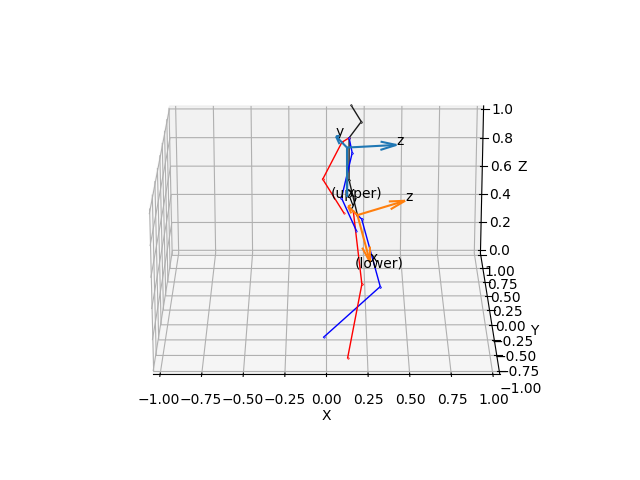

In [4]:
ref_pose = pose3d_s1_walking[500]

pelvis, l_hip, r_hip, torso = get_h36m_keypoints(ref_pose, ['pelvis', 'l_hip', 'r_hip', 'torso'])
l_shoulder, r_shoulder, neck = get_h36m_keypoints(ref_pose, ['l_shoulder', 'r_shoulder', 'neck'])

# lower frame
lower_origin, lower_frame_R = get_lower_torso_frame_from_pose(ref_pose, forward_dir='-z')
lower_frame = generate_vis_frame_from_R(lower_origin, lower_frame_R, name='lower')

# upper frame
upper_origin, upper_frame_R = get_upper_torso_frame_from_pose(ref_pose, forward_dir='-z')
upper_frame = generate_vis_frame_from_R(upper_origin, upper_frame_R, name='upper')

# plot
%matplotlib widget
fig = plt.figure(0)
fig.clear()
lim=1
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, lim), view=(20, -90))
draw_3d_pose(ax, ref_pose)
arrow_scale = 0.3
# lower frame
lower_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:orange")
# upper frame
upper_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:blue")
plt.show()

### Generate frame from torso keypoints (Batch version)

torch.Size([1, 3134, 17, 3])


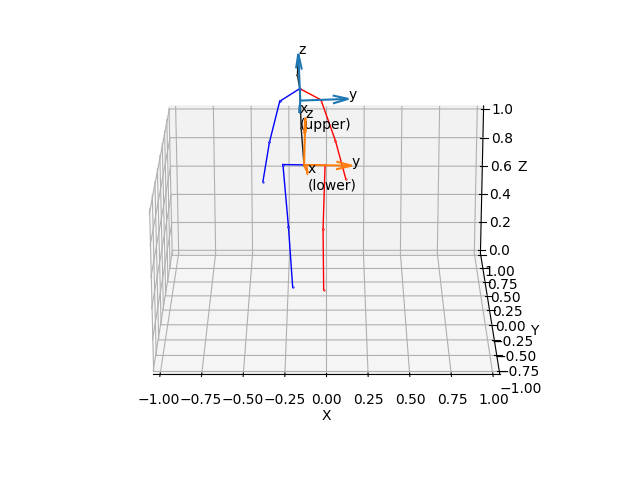

In [4]:
batch_pose = torch.tensor(pose3d_s1_walking, dtype=torch.float32).cuda().unsqueeze(0)
print(batch_pose.shape)

output = get_batch_h36m_keypoints(batch_pose, ['pelvis', 'l_shoulder', 'r_shoulder'])
batch_pelvis, batch_l_shoulder, batch_r_shoulder = output[:, :, 0], output[:, :, 1], output[:, :, 2]

batch_lower_origin, batch_lower_R = get_batch_lower_torso_frame_from_pose(batch_pose)
batch_upper_origin, batch_upper_R = get_batch_upper_torso_frame_from_pose(batch_pose)

# pick specific batch/frame pose
batch_num = 0
frame_num = 0

ref_pose = batch_pose[batch_num, frame_num].cpu().detach().numpy()
lower_origin = batch_lower_origin[batch_num, frame_num].cpu().detach().numpy()
upper_origin = batch_upper_origin[batch_num, frame_num].cpu().detach().numpy()

# lower frame
lower_frame = generate_vis_frame_from_R(lower_origin, batch_lower_R[batch_num, frame_num].cpu().detach().numpy(), name='lower')
# upper frame
upper_frame = generate_vis_frame_from_R(upper_origin, batch_upper_R[batch_num, frame_num].cpu().detach().numpy(), name='upper')

%matplotlib widget
fig = plt.figure(1)
fig.clear()
lim=1
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, lim), view=(20, -90))
draw_3d_pose(ax, ref_pose)
arrow_scale = 0.3
head_length = 0.1
# lower frame
lower_frame.draw3d(scale=arrow_scale, head_length=head_length, color="tab:orange")
# upper frame
upper_frame.draw3d(scale=arrow_scale, head_length=head_length, color="tab:blue")
#generate_world_frame().draw3d()

plt.show()

### Dataset for torso model

pelvis를 기준으로 azimuth, elevation, distance를 다양하게 바꿔가며 다양한 각도에서의 torso 데이터를 획득하기

카메라의 각도는 azimuth, elevation 각도외 coupling되어 항상 사람을 바라보도록 설정함
(pitch = -elev, yaw = azim)

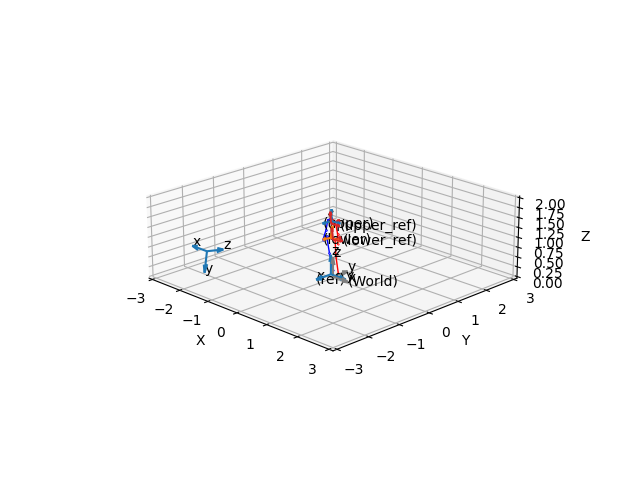

In [7]:
# ---------------------------------------------- Reference pose
ref_pose = pose3d_s1_walking[1]

# ---------------------------------------------- Camera setting
dfx, dfy, dcx, dcy = 0, 0, 0, 0
calib_mat = np.array(cam_54138969_int['calibration_matrix']) + np.array([[dfx, 0, dcx], [0, dfy, dcy], [0, 0, 0]])

# camera parameter
distance_to_person = 4
azim = -90
elev = 10
pelvis_point = ref_pose[0]
cam_origin = azim_elev_to_vec(azim, elev, distance_to_person, pelvis_point, degrees=True)

forward = [-1, 0, 0]
left = [0, -1, 0]
up = np.cross(left,forward)
cam_default_R = np.array([left, up, forward]) # default camera orientation

camera = Camera(origin=cam_origin, 
                calib_mat=calib_mat, 
                cam_default_R=cam_default_R, 
                roll=0,
                pitch=-elev,
                yaw=azim,
                IMAGE_HEIGHT=H, 
                IMAGE_WIDTH=W)

# ---------------------------------------------- 2D Projected pose
ref_pose_projected = projection(ref_pose, camera.cam_proj)

# ---------------------------------------------- Reference frame for upper/lower frame
ref_origin, ref_frame_R = get_reference_frame(cam_origin, pelvis_point)
ref_frame = generate_vis_frame_from_R(ref_origin, ref_frame_R, name='ref')
ref_frame_tf = generate_tf_from_origin_R(ref_origin, ref_frame_R)

# ---------------------------------------------- upper/lower frame
# lower frame
lower_origin, lower_frame_R_world = get_lower_torso_frame_from_pose(ref_pose)
lower_frame_tf = generate_tf_from_origin_R(lower_origin, lower_frame_R_world)
# upper frame
upper_origin, upper_frame_R_world = get_upper_torso_frame_from_pose(ref_pose)
upper_frame_tf = generate_tf_from_origin_R(upper_origin, upper_frame_R_world)
# ---------------------------------------------- upper/lower frame w.r.t. reference frame
upper_frame_tf_ref = inverse_tf(ref_frame_tf) @ upper_frame_tf # ref frame 기준으로 표현한 upper frame - ref -> world -> upper
lower_frame_tf_ref = inverse_tf(ref_frame_tf) @ lower_frame_tf # ref frame 기준으로 표현한 lower frame - ref -> world -> lower
upper_frame_R_ref = upper_frame_tf_ref[:3, :3]
lower_frame_R_ref = lower_frame_tf_ref[:3, :3]
upper_frame_origin_ref = upper_frame_tf_ref[:3, 3]
lower_frame_origin_ref = lower_frame_tf_ref[:3, 3]

# ---------------------------------------------- vis frame
lower_frame = generate_vis_frame_from_R(lower_origin, lower_frame_R_world, name='lower')
upper_frame = generate_vis_frame_from_R(upper_origin, upper_frame_R_world, name='upper')
lower_frame_ref = generate_vis_frame_from_R(lower_frame_origin_ref, lower_frame_R_ref, name='lower_ref')
upper_frame_ref = generate_vis_frame_from_R(upper_frame_origin_ref, upper_frame_R_ref, name='upper_ref')

# ---------------------------------------------- plot
%matplotlib widget
fig = plt.figure(2)
fig.clear()
lim=3
ax = axes_3d(fig, loc=111, xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, 2), view=(20, -45))
draw_3d_pose(ax, ref_pose)
camera.cam_frame.draw3d(show_name=False)
ref_frame.draw3d()
# torso frame w.r.t. world
lower_frame.draw3d(scale=0.3, head_length=0.1, color="tab:orange", show_name=True, show_axis=False)
upper_frame.draw3d(scale=0.3, head_length=0.1, color="tab:blue", show_name=True, show_axis=False)
# torso frame w.r.t. reference frame
lower_frame_ref.draw3d(scale=0.3, head_length=0.1, color="tab:red", show_name=True, show_axis=False)
upper_frame_ref.draw3d(scale=0.3, head_length=0.1, color="tab:red", show_name=True, show_axis=False)
# world frame
generate_world_frame().draw3d(color="tab:gray")

# ax_2d = axes_2d(fig, loc=122, W=W, H=H)
# img = get_2d_pose_image(ref_pose_projected)
# ax_2d.imshow(img)

plt.show()

In [37]:
# torch.cross(torch.ones([1, 253, 17, 3]), torch.tensor([1, 1, 0]).float())

In [9]:
a = torch.ones(1, 243, 3)
b = torch.ones(1, 243, 3) * 2
c = torch.ones(1, 243, 3) * 3

torch.stack([a, b, c], dim=-1)

tensor([[[[1., 2., 3.],
          [1., 2., 3.],
          [1., 2., 3.]],

         [[1., 2., 3.],
          [1., 2., 3.],
          [1., 2., 3.]],

         [[1., 2., 3.],
          [1., 2., 3.],
          [1., 2., 3.]],

         ...,

         [[1., 2., 3.],
          [1., 2., 3.],
          [1., 2., 3.]],

         [[1., 2., 3.],
          [1., 2., 3.],
          [1., 2., 3.]],

         [[1., 2., 3.],
          [1., 2., 3.],
          [1., 2., 3.]]]])

#### batch camera

In [11]:
batch_roll = torch.tensor([0]).unsqueeze(0).unsqueeze(0)
batch_pitch = torch.tensor([-radians(elev)]).unsqueeze(0).unsqueeze(0)
batch_yaw = torch.tensor([radians(azim)]).unsqueeze(0).unsqueeze(0)
batch_rot_z = batch_rot_z_matrix(batch_roll)
batch_rot_y = batch_rot_y_matrix(batch_yaw)
batch_rot_x = batch_rot_x_matrix(batch_pitch)
batch_cam_default_R = torch.from_numpy(cam_default_R).unsqueeze(0).unsqueeze(0).float()
batch_R = (batch_rot_z @ batch_rot_y @ batch_rot_x).transpose(2, 3) @ batch_cam_default_R
batch_R

tensor([[[[-1.0000e+00,  4.3711e-08,  0.0000e+00],
          [-7.5904e-09, -1.7365e-01, -9.8481e-01],
          [ 4.3047e-08,  9.8481e-01, -1.7365e-01]]]])

In [12]:
camera.R

array([[-1.00000000e+00, -2.22044605e-16,  0.00000000e+00],
       [ 3.85576410e-17, -1.73648178e-01, -9.84807753e-01],
       [-2.18671248e-16,  9.84807753e-01, -1.73648178e-01]])

In [13]:
batch_C = torch.from_numpy(cam_origin).unsqueeze(0).unsqueeze(0).float()
batch_t = (- batch_R @ batch_C.unsqueeze(-1))
batch_t.shape

torch.Size([1, 1, 3, 1])

In [14]:
camera.t

array([[-140.77800512],
       [ 931.73731543],
       [4094.17817154]])

In [15]:
batch_intrinsic = torch.from_numpy(calib_mat).unsqueeze(0).unsqueeze(0).float()
batch_cam_proj = batch_intrinsic @ torch.cat([batch_R, batch_t], dim=-1)
batch_cam_proj

tensor([[[[-1.1450e+03,  5.0475e+02, -8.9002e+01,  1.9372e+03],
          [ 1.3507e-05,  3.0901e+02, -1.2159e+03,  3.1761e+03],
          [ 4.3047e-08,  9.8481e-01, -1.7365e-01,  4.0942e+00]]]])

In [16]:
camera.cam_proj

array([[-1.14504940e+03,  5.04754848e+02, -8.90018983e+01,
         1.93723847e+03],
       [-6.86129193e-14,  3.09005118e+02, -1.21591170e+03,
         3.17605375e+03],
       [-2.18671248e-16,  9.84807753e-01, -1.73648178e-01,
         4.09417817e+00]])

In [17]:
batch_origin = torch.from_numpy(cam_origin).unsqueeze(0).unsqueeze(0).float()
batch_camera = BatchCamera(batch_origin, calib_mat, batch_roll, batch_pitch, batch_yaw, cam_default_R)

In [18]:
batch_camera.batch_cam_proj, batch_camera.batch_t

(tensor([[[[-1.1450e+03,  5.0475e+02, -8.9002e+01,  1.9372e+03],
           [ 1.3507e-05,  3.0901e+02, -1.2159e+03,  3.1761e+03],
           [ 4.3047e-08,  9.8481e-01, -1.7365e-01,  4.0942e+00]]]]),
 tensor([[[[-0.1408],
           [ 0.9317],
           [ 4.0942]]]]))

#### random batch camera

In [19]:
torch.rand(1, 243, 1).shape

torch.Size([1, 243, 1])

In [21]:
batch_pitch = torch.rand(1, 243, 1)
batch_yaw = torch.rand(1, 243, 1)
batch_camera = BatchCamera(batch_origin, calib_mat, batch_roll, batch_pitch, batch_yaw, cam_default_R)

In [22]:
batch_camera.batch_cam_proj

tensor([[[[ 2.7300e+02, -1.1647e+03,  3.7779e+02, -5.0845e+03],
          [-1.0316e+03, -5.9610e+02, -3.9303e+02, -1.8122e+03],
          [-5.8513e-01, -3.3812e-01,  7.3709e-01, -2.5913e+00]],

         [[ 4.5385e+02, -1.1243e+03,  3.2221e+02, -4.8121e+03],
          [-8.4294e+02, -7.3731e+02, -5.6547e+02, -2.0513e+03],
          [-5.8536e-01, -5.1201e-01,  6.2865e-01, -3.0878e+00]],

         [[-1.7883e+02, -1.1655e+03,  4.2832e+02, -5.2334e+03],
          [-1.2340e+03, -1.0988e+02, -1.9744e+02, -2.7745e+02],
          [-5.4706e-01, -4.8711e-02,  8.3568e-01, -1.6265e+00]],

         ...,

         [[-2.5859e+02, -1.1738e+03,  3.5943e+02, -5.1645e+03],
          [-1.1646e+03, -1.0750e+02, -4.5391e+02,  1.5921e+02],
          [-7.0987e-01, -6.5524e-02,  7.0128e-01, -1.4956e+00]],

         [[-4.8173e+02, -1.1564e+03,  6.7853e+01, -4.6536e+03],
          [-6.6216e+02, -1.5134e+01, -1.0655e+03,  1.5834e+03],
          [-9.9094e-01, -2.2648e-02,  1.3239e-01, -4.4275e-01]],

         [[-2.4

### batch azim_elev_to_vec

In [23]:
batch_azim = torch.ones(1, 243, 1) * radians(90)
batch_elev = torch.ones(1, 243, 1) * radians(0)
batch_origin = torch.ones(1, 243, 3)
batch_magnitude = torch.ones(1, 243, 1) * 1
batch_x = batch_magnitude * torch.cos(batch_azim) * torch.cos(batch_elev)
batch_y = batch_magnitude * torch.sin(batch_azim) * torch.cos(batch_elev)
batch_z = batch_magnitude * torch.sin(batch_elev)
batch_vec = torch.cat([batch_x, batch_y, batch_z], dim=-1) + batch_origin
batch_x.shape, batch_y.shape, batch_z.shape, batch_vec.shape

(torch.Size([1, 243, 1]),
 torch.Size([1, 243, 1]),
 torch.Size([1, 243, 1]),
 torch.Size([1, 243, 3]))

In [24]:
batch_x[0, 0], batch_y[0, 0], batch_z[0, 0], batch_vec[0, 0]

(tensor([-4.3711e-08]),
 tensor([1.]),
 tensor([0.]),
 tensor([1.0000, 2.0000, 1.0000]))

#### with slider

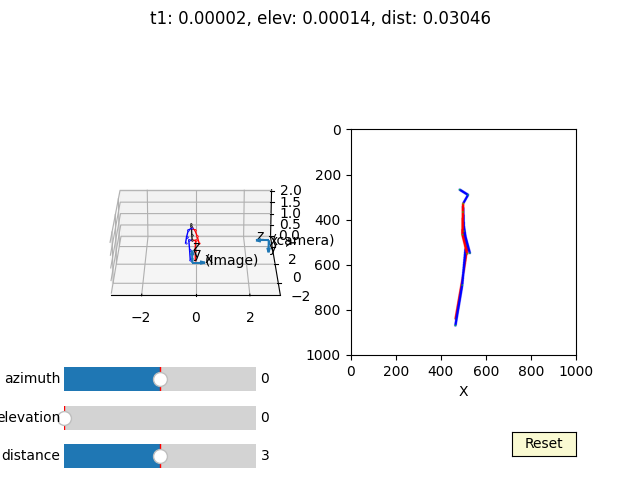

In [26]:
from matplotlib.widgets import Slider, Button

ref_torso = pose3d_s1_walking[0]
pelvis_point = ref_pose[0]

%matplotlib widget
fig = plt.figure(3)
fig.clear()
lim=3
ax = axes_3d(fig, loc=121, xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, 2), view=(20, -90))
ax_2d = axes_2d(fig, loc=122, W=W, H=H)

ax_azim  = fig.add_axes([0.1, 0.16, 0.3, 0.1]) # left, bottom, width, height
ax_elev  = fig.add_axes([0.1, 0.08, 0.3, 0.1])
ax_dist  = fig.add_axes([0.1, 0.0, 0.3, 0.1])
ax_reset = fig.add_axes([0.8, 0.05, 0.1, 0.05])

s_azim = Slider(ax = ax_azim, label = 'azimuth', valmin = -180, valmax = 180, valinit = 0, orientation="horizontal")
s_elev = Slider(ax = ax_elev, label = 'elevation', valmin = 0, valmax = 30, valinit = 0, orientation="horizontal")
s_dist = Slider(ax = ax_dist, label = 'distance', valmin = 1, valmax = 5, valinit = 3, orientation="horizontal")
button = Button(ax_reset, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

camera = Camera(origin=cam_origin, 
                calib_mat=calib_mat, 
                cam_default_R=cam_default_R, 
                roll=0,
                pitch=-elev,
                yaw=azim,
                IMAGE_HEIGHT=H, 
                IMAGE_WIDTH=W)

def reset(event):
    s_azim.reset()
    s_elev.reset()
    s_dist.reset()

def update(val):
    # update joint angles
    azim = s_azim.val
    elev = s_elev.val
    dist = s_dist.val
    
    s1 = time.time()
    cam_origin = dist * azim_elev_to_vec(azim, elev, degrees=True) + pelvis_point
    t1 = time.time() - s1
    
    s2 = time.time()
    camera.update_camera_parameter(origin=cam_origin, pitch=-elev, yaw=azim)
    t2 = time.time() - s2

    # 2d projection
    ref_pose_projected = projection(ref_pose, camera.cam_proj)
    
    # ref frame
    ref_forward = (cam_origin - pelvis_point)*np.array([1, 1, 0])
    ref_forward /= np.linalg.norm(ref_forward)
    ref_up = np.array([0, 0, 1])
    ref_left = np.cross(ref_up, ref_forward)
    ref_frame = ReferenceFrame(
        origin=pelvis_point*np.array([1, 1, 0]), 
        dx=ref_forward, 
        dy=ref_left,
        dz=ref_up,
        name="Image",
    )
        
    # clear plot
    t3 = time.time()
    last_azim, last_elev = ax.azim, ax.elev
    ax.cla()
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(0, 2)
    ax.view_init(elev=last_elev, azim=last_azim)
    ax.set_aspect('equal', 'box')
    # ax = axes_3d(fig, loc=121, xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, 2), view=(20, -90))
    # ax_2d.cla()
    # ax_2d = axes_2d(fig, loc=122, W=W, H=H)
    
    # 3d plot
    plt.sca(ax)
    #ax = axes_3d(fig, loc=121, xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, 2), view=(20, -90))
    draw_3d_pose(ax, ref_pose)
    camera.cam_frame.draw3d()
    ref_frame.draw3d()
    
    # 2d plot
    plt.sca(ax_2d)  
    img = get_2d_pose_image(ref_pose_projected)
    ax_2d.imshow(img)
    t3 = time.time() - t3
    plt.suptitle('t1: {:.5f}, elev: {:.5f}, dist: {:.5f}'.format(t1, t2, t3))
    

# map the update function to all sliders
button.on_clicked(reset)
s_azim.on_changed(update)
s_elev.on_changed(update)
s_dist.on_changed(update)

# initialize plot
update(0)
plt.show()

In [28]:
torch.ones(batch_pose.shape[0], batch_pose.shape[1], 1).shape

torch.Size([1, 3134, 1])

In [29]:
torch.ones(batch_pose.shape[0], batch_pose.shape[1], 1) * torch.deg2rad(torch.tensor(range(batch_pose.shape[1]))).unsqueeze(0).unsqueeze(-1)

tensor([[[0.0000e+00],
         [1.7453e-02],
         [3.4907e-02],
         ...,
         [5.4646e+01],
         [5.4664e+01],
         [5.4681e+01]]])

In [30]:
torch.sin(torch.tensor(range(batch_pose.shape[1]))) *radians(30).unsqueeze(0).unsqueeze(-1)

AttributeError: 'float' object has no attribute 'unsqueeze'

### Load H36M dataset

In [28]:
(torch.ones(1, 1440, 3, 3) @ torch.ones(1, 1440, 3, 1)).shape

torch.Size([1, 1440, 3, 1])

In [29]:
torch.ones(batch_pose.shape[0], batch_pose.shape[1], batch_pose.shape[2], 1).shape

torch.Size([1, 3134, 17, 1])

In [30]:
batch_pose.device

device(type='cuda', index=0)

In [31]:
homo = torch.cat((batch_pose, torch.ones(batch_pose.shape[0], batch_pose.shape[1], batch_pose.shape[2], 1).cuda()), dim=3)
homo.shape, homo.device

(torch.Size([1, 3134, 17, 4]), device(type='cuda', index=0))

In [32]:
batch_camera.batch_cam_proj.transpose(-2, -1).shape

torch.Size([1, 243, 4, 3])

In [33]:
subject = 'S1'
action_list = h36m_3d_world._data[subject].keys()
for action in action_list:
    pose3d = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
    batch_pose = torch.tensor(pose3d, dtype=torch.float32).unsqueeze(0)
    batch_pelvis = get_batch_h36m_keypoints(batch_pose, ['pelvis'])[:, :, 0]

    batch_lower_origin, batch_lower_R = get_batch_lower_torso_frame_from_pose(batch_pose)
    batch_upper_origin, batch_upper_R = get_batch_upper_torso_frame_from_pose(batch_pose)
    
    # ---------------------------------------------- Camera setting
    dfx, dfy, dcx, dcy = 0, 0, 0, 0
    calib_mat = np.array(cam_54138969_int['calibration_matrix']) + np.array([[dfx, 0, dcx], [0, dfy, dcy], [0, 0, 0]])

    forward = [-1, 0, 0]
    left = [0, -1, 0]
    up = np.cross(left, forward)
    cam_default_R = np.array([left, up, forward]) # default camera orientation
    
    batch_roll = torch.zeros(batch_pose.shape[0], batch_pose.shape[1], 1)
    batch_azim = torch.ones(batch_pose.shape[0], batch_pose.shape[1], 1) * torch.deg2rad(torch.tensor(range(batch_pose.shape[1]))).unsqueeze(0).unsqueeze(-1) # continuous
    batch_elev = torch.ones(batch_pose.shape[0], batch_pose.shape[1], 1) * ((torch.sin(torch.deg2rad(torch.tensor(range(batch_pose.shape[1])))) + 1) * radians(15)).unsqueeze(0).unsqueeze(-1)
    
    #batch_azim = torch.rand(batch_pose.shape[0], batch_pose.shape[1], 1) * radians(360)
    #batch_elev = torch.rand(batch_pose.shape[0], batch_pose.shape[1], 1) * radians(30)
    
    batch_dist_to_person = torch.ones(batch_pose.shape[0], batch_pose.shape[1], 1) * 3
    batch_cam_origin = batch_azim_elev_to_vec(batch_azim=batch_azim, 
                                              batch_elev=batch_elev, 
                                              batch_magnitude=batch_dist_to_person, 
                                              batch_origin=batch_pelvis)
    batch_camera = BatchCamera(batch_origin=batch_cam_origin, 
                               calib_mat=calib_mat, 
                               batch_roll=batch_roll, 
                               batch_pitch=-batch_elev, 
                               batch_yaw=batch_azim, 
                               cam_default_R=cam_default_R)
    
    batch_pose_projected = batch_projection(batch_pose, batch_camera.batch_cam_proj)
    
    batch_ref_origin, batch_ref_R = get_batch_reference_frame(batch_cam_origin, batch_pelvis)
    batch_ref_tf = generate_batch_tf_from_batch_origin_R(batch_ref_origin, batch_ref_R)
    
    batch_upper_frame_tf = generate_batch_tf_from_batch_origin_R(batch_upper_origin, batch_upper_R)
    batch_upper_frame_tf_ref = batch_inverse_tf(batch_ref_tf) @ batch_upper_frame_tf # ref frame 기준으로 표현한 upper frame - ref -> world -> upper
    batch_upper_frame_R_ref = batch_upper_frame_tf_ref[:, :, :3, :3]
    batch_upper_frame_origin_ref = batch_upper_frame_tf_ref[:, :, :3, 3]
    
    batch_lower_frame_tf = generate_batch_tf_from_batch_origin_R(batch_lower_origin, batch_lower_R)
    batch_lower_frame_tf_ref = batch_inverse_tf(batch_ref_tf) @ batch_lower_frame_tf # ref frame 기준으로 표현한 lower frame - ref -> world -> lower
    batch_lower_frame_R_ref = batch_lower_frame_tf_ref[:, :, :3, :3]
    batch_lower_frame_origin_ref = batch_lower_frame_tf_ref[:, :, :3, 3]
   
    # plot_mode = '2d3d'
    # videowriter = imageio.get_writer('{}_{}_torso_frame_{}_with_continous_full.mp4'.format(subject, action, plot_mode), fps=30)
    # for batch_num in range(batch_pose.shape[0]):
        
    #     for frame_num in tqdm(range(0, 1440)):
            
    #         ref_pose = batch_pose[batch_num, frame_num].cpu().detach().numpy()
            
    #         # get torso frame
    #         lower_frame_origin = batch_lower_origin[batch_num, frame_num].cpu().detach().numpy()
    #         lower_frame_R = batch_lower_R[batch_num, frame_num].cpu().detach().numpy()
    #         upper_frame_origin = batch_upper_origin[batch_num, frame_num].cpu().detach().numpy()
    #         upper_frame_R = batch_upper_R[batch_num, frame_num].cpu().detach().numpy()
            
    #         lower_frame = generate_vis_frame_from_R(lower_frame_origin, lower_frame_R, name='lower')
    #         upper_frame = generate_vis_frame_from_R(upper_frame_origin, upper_frame_R, name='upper')

    #         # update camera parameter
    #         # pelvis_point = ref_pose[0]
    #         # azim += 1
    #         # cam_origin = azim_elev_to_vec(azim, elev, distance_to_person, pelvis_point, degrees=True)
    #         # camera.update_camera_parameter(pitch=-elev, yaw=azim)
            
    #         # 2d projection
    #         #ref_pose_projected = projection(ref_pose, batch_camera.batch_cam_proj[batch_num, frame_num].cpu().detach().numpy())
    #         ref_pose_projected = batch_pose_projected[batch_num, frame_num].cpu().detach().numpy()
            
    #         # camera vis frame
    #         cam_ext = {'R': batch_camera.batch_R[batch_num, frame_num].cpu().detach().numpy(), 
    #                    't': batch_camera.batch_t[batch_num, frame_num].cpu().detach().numpy()}
    #         cam_frame = generate_camera_frame(cam_ext, mm_to_m=False)
            
    #         ref_origin = batch_ref_origin[batch_num, frame_num].cpu().detach().numpy()
    #         ref_R = batch_ref_R[batch_num, frame_num].cpu().detach().numpy()
    #         ref_frame = generate_vis_frame_from_R(ref_origin, ref_R, name='ref')
            
    #         # plot
    #         fig = plt.figure(3, figsize=(15, 5))
    #         fig.clear()
    #         lim=3
    #         if plot_mode == '3d':
    #             ## 3d plot
    #             ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, 2), view=(20, -90))
    #             draw_3d_pose(ax, ref_pose)
    #             arrow_scale = 0.3
    #             lower_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:orange", show_name=False, show_axis=False)
    #             upper_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:blue", show_name=False, show_axis=False)
    #             ref_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:red", show_name=False, show_axis=False)
    #         elif plot_mode == '2d':
    #             ## 2d plot
    #             ax_2d = axes_2d(fig, W=W, H=H)
    #             img = get_2d_pose_image(ref_pose_projected)
    #             ax_2d.imshow(img)
    #         elif plot_mode == '2d3d':
    #             ax = axes_3d(fig, rect=[0, 0, 0.8, 1], xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, 2), view=(20, -90))
    #             draw_3d_pose(ax, ref_pose)
    #             arrow_scale = 0.3
    #             lower_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:orange", show_name=False, show_axis=False)
    #             upper_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:blue", show_name=False, show_axis=False)
    #             ref_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:red", show_name=False, show_axis=False)
    #             cam_frame.draw3d(show_name=False)
                
    #             ax_2d = axes_2d(fig, rect=[0.8, 0.6, 0.2, 0.2], W=W, H=H, show_axis=False)
    #             img = get_2d_pose_image(ref_pose_projected)
    #             ax_2d.imshow(img)
            
    #         canvas = FigureCanvas(fig)
    #         canvas.draw()
    #         image_from_plot = np.array(canvas.renderer._renderer)
    #         image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)
    #         videowriter.append_data(image_from_plot)
    # videowriter.close()

    break

tensor([2.8978, 0.0000, 0.7765])
tensor([-0.2249, -0.2010,  0.9419])
tensor([ 2.6728, -0.2010,  1.7184])
torch.Size([1, 1440, 3, 3]) torch.Size([1, 1440, 3, 1])
torch.Size([1, 1440, 3, 3]) torch.Size([1, 1440, 3, 1])


In [34]:
calib_mat

array([[1.14504940e+03, 0.00000000e+00, 5.12541505e+02],
       [0.00000000e+00, 1.14378110e+03, 5.15451487e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

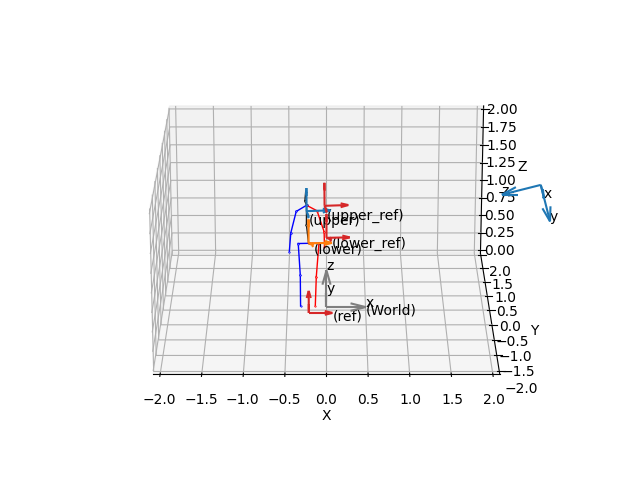

In [35]:
ref_pose = batch_pose[batch_num, frame_num].cpu().detach().numpy()
# get torso frame
lower_frame_origin = batch_lower_origin[batch_num, frame_num].cpu().detach().numpy()
lower_frame_R = batch_lower_R[batch_num, frame_num].cpu().detach().numpy()

upper_frame_origin = batch_upper_origin[batch_num, frame_num].cpu().detach().numpy()
upper_frame_R = batch_upper_R[batch_num, frame_num].cpu().detach().numpy()

upper_frame_origin_ref = batch_upper_frame_origin_ref[batch_num, frame_num].cpu().detach().numpy()
upper_frame_R_ref = batch_upper_frame_R_ref[batch_num, frame_num].cpu().detach().numpy()

lower_frame_origin_ref = batch_lower_frame_origin_ref[batch_num, frame_num].cpu().detach().numpy()
lower_frame_R_ref = batch_lower_frame_R_ref[batch_num, frame_num].cpu().detach().numpy()

ref_origin = batch_ref_origin[batch_num, frame_num].cpu().detach().numpy()
ref_R = batch_ref_R[batch_num, frame_num].cpu().detach().numpy()

ref_frame = generate_vis_frame_from_R(ref_origin, ref_R, name='ref')
lower_frame = generate_vis_frame_from_R(lower_frame_origin, lower_frame_R, name='lower')
upper_frame = generate_vis_frame_from_R(upper_frame_origin, upper_frame_R, name='upper')
upper_freme_ref = generate_vis_frame_from_R(upper_frame_origin_ref, upper_frame_R_ref, name='upper_ref')
lower_frame_ref = generate_vis_frame_from_R(lower_frame_origin_ref, lower_frame_R_ref, name='lower_ref')

ref_pose_projected = batch_pose_projected[batch_num, frame_num].cpu().detach().numpy()
cam_ext = {'R': batch_camera.batch_R[batch_num, frame_num].cpu().detach().numpy(), 
           't': batch_camera.batch_t[batch_num, frame_num].cpu().detach().numpy()}
cam_frame = generate_camera_frame(cam_ext, mm_to_m=False)


%matplotlib widget
fig = plt.figure(3)
fig.clear()
lim=2
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, lim), view=(20, -90))
draw_3d_pose(ax, ref_pose)
arrow_scale = 0.3
cam_frame.draw3d(show_name=False)
lower_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:orange", show_name=True, show_axis=False)
upper_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:blue", show_name=True, show_axis=False)
ref_frame.draw3d(scale=arrow_scale, head_length=0.1, color="tab:red", show_name=True, show_axis=False)
upper_freme_ref.draw3d(scale=arrow_scale, head_length=0.1, color="tab:red", show_name=True, show_axis=False)
lower_frame_ref.draw3d(scale=arrow_scale, head_length=0.1, color="tab:red", show_name=True, show_axis=False)
world_frame.draw3d(color="tab:gray")
plt.show()

In [5]:
calib_mat

NameError: name 'calib_mat' is not defined

### Batch rotation matric to quaternion

In [36]:
# Example batch of rotation matrices (N, 3, 3)
matrix = Rotation.from_rotvec(np.pi/4 * np.array([1, 0, 0])).as_matrix()
print(matrix)

rotation_matrices = torch.from_numpy(matrix).unsqueeze(0).unsqueeze(0).repeat(4, 243, 1, 1)  # Replace with your batch of matrices
# Convert to quaternions (N, 4)
quaternions = matrix_to_quaternion(rotation_matrices) # w x y z

print("Quaternions:", quaternions[0, 0])


[[ 1.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678]
 [ 0.          0.70710678  0.70710678]]
Quaternions: tensor([0.9239, 0.3827, 0.0000, 0.0000], dtype=torch.float64)


### TorsoDataset3D class

In [50]:
### will be moved to MotionBERT/lib/data/dataset_motion_3d.py
class TorsoDataset3D():
    def __init__(self, args, data_split, dataset='h36m'):
        if dataset == 'h36m': self.h36m_3d_world, self.h36m_cam_param = load_h36m()
        else: raise NotImplementedError
        
        if   data_split == 'train': subject_list=['S1', 'S5', 'S6', 'S7', 'S8']
        elif data_split == 'test':  subject_list=['S9', 'S11']
        else: raise NotImplementedError
        
        # initialize virtual camera
        self.set_cam_default_R()
        cam_info = h36m_3d_world._data['S1']['Walking']['cameras']
        self.cam_param = get_cam_param(h36m_3d_world._data['S1']['Walking']['cameras'], 'S1', self.h36m_cam_param)
        self.W, self.H = self.cam_param['54138969']['W'], self.cam_param['54138969']['H']
        calib_mat = self.cam_param['54138969']['int']['calibration_matrix']
        #target_point = [0, 0, 0]
        #self.camera = self.generate_virtual_camera(target_point, calib_mat, self.W, self.H)
        
        self.input_2d_list = []
        self.torso_3d_list = []
        self.lower_frame_3d = []
        self.upper_frame_3d = []
        
        # generate dataset
        for subject in subject_list:
            action_list = h36m_3d_world._data[subject].keys()
            for action in action_list:
                pose3d = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
                print(subject, action, pose3d.shape)
                batch_pose = torch.tensor(pose3d, dtype=torch.float32).cuda().unsqueeze(0)
                
                batch_torso = batch_pose[:, :, [0, 1, 4, 7, 8, 9, 10, 11, 14], :]
                batch_lower_origin, batch_lower_R = get_batch_lower_torso_frame_from_pose(batch_pose)
                batch_upper_origin, batch_upper_R = get_batch_upper_torso_frame_from_pose(batch_pose)
                
                
                # generate batch virtual camera
                batch_roll = torch.zeros(batch_pose.shape[0], batch_pose.shape[1], 1)
                batch_azim = torch.rand(batch_pose.shape[0], batch_pose.shape[1], 1) * radians(360)
                batch_elev = torch.rand(batch_pose.shape[0], batch_pose.shape[1], 1) * radians(30)
                batch_dist_to_person = torch.ones(batch_pose.shape[0], batch_pose.shape[1], 1) * 3
                batch_cam_origin = batch_azim_elev_to_vec(batch_azim=batch_azim, 
                                                          batch_elev=batch_elev, 
                                                          batch_magnitude=batch_dist_to_person, 
                                                          batch_origin=batch_pelvis)
                batch_camera = BatchCamera(batch_origin=batch_cam_origin, 
                                           calib_mat=calib_mat, 
                                           batch_roll=batch_roll, 
                                           batch_pitch=-batch_elev, 
                                           batch_yaw=batch_azim, 
                                           cam_default_R=self.cam_default_R)
                
                batch_pose_projected = batch_projection(batch_pose, batch_camera.batch_cam_proj)
                
                batch_ref_origin, batch_ref_R = batch_get_reference_frame(batch_cam_origin, batch_pelvis)
                batch_ref_tf = generate_batch_tf_from_batch_origin_R(batch_ref_origin, batch_ref_R)
                
                batch_upper_frame_tf = generate_batch_tf_from_batch_origin_R(batch_upper_origin, batch_upper_R)
                batch_upper_frame_tf_ref = batch_inverse_tf(batch_ref_tf) @ batch_upper_frame_tf # ref frame 기준으로 표현한 upper frame - ref -> world -> upper
                batch_upper_frame_R_ref = batch_upper_frame_tf_ref[:, :, :3, :3]
                batch_upper_frame_origin_ref = batch_upper_frame_tf_ref[:, :, :3, 3]
                
                batch_lower_frame_tf = batch_generate_tf_from_batch_origin_R(batch_lower_origin, batch_lower_R)
                batch_lower_frame_tf_ref = batch_inverse_tf(batch_ref_tf) @ batch_lower_frame_tf # ref frame 기준으로 표현한 lower frame - ref -> world -> lower
                batch_lower_frame_R_ref = batch_lower_frame_tf_ref[:, :, :3, :3]
                batch_lower_frame_origin_ref = batch_lower_frame_tf_ref[:, :, :3, 3]
                
                # store data
                self.input_2d_list.append(batch_pose_projected)
                
    def set_cam_default_R(self):
        forward = [-1, 0, 0]
        left = [0, -1, 0]
        up = np.cross(left,forward)
        self.cam_default_R = np.array([left, up, forward]) 
                              
    def generate_virtual_camera(self, target_point, calib_mat, W=1000, H=1000, azim=0, elev=0, dist_to_person=3, dfx=0, dfy=0, dcx=0, dcy=0):
        # ---------------------------------------------- Camera setting
        calib_mat = np.array(calib_mat) + np.array([[dfx, 0, dcx], [0, dfy, dcy], [0, 0, 0]])
        cam_origin = self.azim_elev_to_vec(azim, elev, dist_to_person, target_point, degrees=True)
        camera = Camera(origin=cam_origin, 
                        calib_mat=calib_mat, 
                        cam_default_R=self.cam_default_R, 
                        roll=0,
                        pitch=-elev,
                        yaw=azim,
                        IMAGE_HEIGHT=H, 
                        IMAGE_WIDTH=W)
        return camera
        
    def azim_elev_to_vec(self, azim, elev, magnitude=1, origin=[0, 0, 0], degrees=False):
        if degrees:
            azim = math.radians(azim)
            elev = math.radians(elev)
        x = magnitude * np.cos(azim) * np.cos(elev) + origin[0]
        y = magnitude * np.sin(azim) * np.cos(elev) + origin[1]
        z = magnitude * np.sin(elev) + origin[2]
        return np.array([x,y,z])
        
    def __getitem__(self, index):
        input_2d = 0
        torso_3d = 0
        lower_frame_3d = 0
        upper_frame_3d = 0
        return torch.FloatTensor(input_2d), torch.FloatTensor(torso_3d), torch.FloatTensor(lower_frame_3d), torch.FloatTensor(upper_frame_3d)